# FastSLAM2.0

In [8]:
import sys
sys.path.append('../scripts/')
from kf import * # this also import Mcl class
%matplotlib widget

In [9]:
class EstimatedLandmark(Landmark): # add cov to Landmark.
    def __init__(self):
        super().__init__(0,0)
        self.cov = None
        
    def draw(self, ax, elems):
        if self.cov is None:
            return
        
        center = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(center)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:"+str(self.id), fontsize=10))
        
        ellipse = sigma_ellipse(self.pos, self.cov, 3)
        elems.append(ax.add_patch(ellipse))

In [3]:
class MapParticle(Particle):
    def __init__(self, init_pose, weight, landmark_num):
        # same with FastSLAM
        super().__init__(init_pose, weight)
        
        self.map = Map() # defined in IdealRobot.py
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
            
                
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        # same with FastSLAM
        landmark.pos = (z[0] * np.array([np.cos(self.pose[2]+z[1]), 
                                        np.sin(self.pose[2]+z[1])]).T 
                        + self.pose[0:2]) # z=(x,y,phi), self.pose=(x,y,theta)
        H = -matH(self.pose, landmark.pos)[0:2,0:2] # in kf.py
        Q = matQ(distance_dev_rate*z[0], direction_dev)
        landmark.cov = np.linalg.inv(H.T.dot(np.linalg.inv(Q).dot(H)))

                        
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):
        est_z = IdealCamera.observation_function(self.pose, landmark.pos) #h(m^)
        if est_z[0] < 0.01:
            return
        
        # landmark update
        H = -matH(self.pose, landmark.pos)[0:2,0:2]
        Q = matQ(distance_dev_rate * est_z[0], direction_dev)
        K = landmark.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)))
        landmark.pos += K.dot(z - est_z) #(8.39)
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov) #(8.40)
 
        # weight update is implemented in motion_update2 for FastSLAM2
        # # trajectory(weight) update
        # Q_z = H.dot(landmark.cov).dot(H.T) + Q
        # self.weight *= multivariate_normal(mean=est_z, cov=Q_z).pdf(z)
        
    def observation_update(self, observation, distance_dev_rate, direction_dev):
        # same with FastSLAM
        for d in observation:
            z = d[0] #landmark's (l,phi)
            landmark = self.map.landmarks[d[1]]
            
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)
        
    def motion_update2(self, nu, omega, time, motion_noise_stds, observation, distance_dev_rate, direction_dev): 
        # prediction + landmark correction
        # add observation, motion_noise_stds to motion_update()
        M = matM(nu, omega, time, motion_noise_stds) # covariance of u. 2x2
        A = matA(nu, omega, time, self.pose[2]) # map: u->x 2x2
        R_t = A.dot(M).dot(A.T) # covariance of x. 2x2
        x_hat = IdealRobot.state_transition(nu, omega, time, self.pose) 
        # time means dt after self.pose was computed. dim=2 (8.58)
        
        # correction
        for obs in observation:
            # weight update
            zt_hat, Q_zt, H_xt = self.drawing_params(x_hat, self.map.landmarks[obs[1]], distance_dev_rate, direction_dev)
            Sigma_zt = H_xt.dot(R_t).dot(H_xt.T) + Q_zt # eq (8.77)
            self.weight *= multivariate_normal(mean=zt_hat, cov=Sigma_zt).pdf(obs[0]) #(8.79)
            
            # position correction as drawing.
            x_hat, R_t = self.gauss_for_drawing(x_hat, R_t, obs[0], self.map.landmarks[obs[1]], distance_dev_rate, direction_dev)
        
        # add dim3 
        R_t +=np.eye(3)*1.0e-10
        
        self.pose = multivariate_normal(mean=x_hat, cov=R_t).rvs()
        
    # note: Here draw means extract one particle from the distribution. 
    def gauss_for_drawing(self, x_hat, R_t, z, landmark, distance_dev_rate, direction_dev):
        zt_hat, Q_zt, H_xt = self.drawing_params(x_hat, landmark, distance_dev_rate, direction_dev)
        K = R_t.dot(H_xt.T).dot(np.linalg.inv(Q_zt + H_xt.dot(R_t).dot(H_xt.T))) #(8.68)
        mu_t = K.dot(z - zt_hat) + x_hat #(8.69)
        Sigma_t = (np.eye(3) - K.dot(H_xt)).dot(R_t) #(8.70)
        
        return mu_t, Sigma_t 

    def drawing_params(self, x_hat, landmark, distance_dev_rate, direction_dev):
        # linearlize h(x,m)
        d_landmark = np.hypot(*(x_hat[0:2] - landmark.pos))
        Q_zt_hat = matQ(distance_dev_rate*d_landmark, direction_dev)

        ##パーティクルの姿勢と地図からセンサ値の分布の共分散行列を計算##
        zt_hat = IdealCamera.observation_function(x_hat, landmark.pos)
        H_m = - matH(x_hat, landmark.pos)[0:2,0:2] #(8.62)
        H_xt = matH(x_hat, landmark.pos) #(8.63)       
        Q_zt = H_m.dot(landmark.cov).dot(H_m.T) + Q_zt_hat #(8.65)        
        
        return zt_hat, Q_zt, H_xt

In [4]:
class FastSlam2Agent(EstimationAgent): #EstimationAgent is in mcl.py, which is Agent+Estimator.  
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(time_interval, nu, omega, estimator)
        
    def decision(self, observation=None): 
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval, observation) #add an observation.
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega

In [5]:
class FastSlam2(Mcl):
    def __init__(self, init_pose, num_particle, num_landmark, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},                  
                 distance_dev_rate=0.14, direction_dev=0.05):
        #same with FastSlam
        super().__init__(None, init_pose, num_particle, motion_noise_stds, distance_dev_rate, direction_dev) # let envmap None.
        self.particles = [MapParticle(init_pose, 1.0/num_particle, num_landmark) for i in range(num_particle)]
        self.ml = self.particles[0] # temporally
        self.motion_noise_stds = motion_noise_stds # add to use in motion_update2()
        
    def draw(self, ax, elems): 
        #same with FastSlam
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)
        
    def observation_update(self, observation): 
        #same with FastSlam
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) #MapParticle's function
        self.set_ml() # defined in Mcl.
        self.resampling()
        
    def motion_update(self, nu, omega, time, observation):
        not_first_obs = []
        for obs in observation:
            if self.particles[0].map.landmarks[obs[1]].cov is not None: # check first particle's map covariance
                not_first_obs.append(obs)
                
        if len(not_first_obs) > 0:
            for p in self.particles:
                p.motion_update2(nu, omega, time, \
                                 self.motion_noise_stds, not_first_obs, \
                                 self.distance_dev_rate, self.direction_dev) # Mcl's one.
        else:
            for p in self.particles: # use Mcl's motion_update().
                p.motion_update(nu, omega, time, \
                                self.motion_noise_rate_pdf) # Mcl's one. 

In [12]:
def trial(cambias=True):
    time_interval = 0.1
    world = World(30, time_interval, debug = False)
    
    map = Map() # defined in ideal_robot.py
    for landmark in [(-4,2),(2,-3),(3,3)]: 
        map.append_landmark((Landmark(*landmark)))
    world.append(map)
    
    init_pose = np.array([0,0,0]).T
    num_particle = 10
    fastslam = FastSlam2(init_pose, num_particle, len(map.landmarks)) # delete map.
    nu = 0.2 
    omega = 10.0/180*math.pi
    agent = FastSlam2Agent(time_interval, nu, omega, fastslam) 
    
    if cambias:
        robot = Robot(init_pose, sensor=Camera(map), agent=agent, color='red')
    else:
        robot = Robot(init_pose, sensor=Camera(map,distance_bias_rate_stddev=0,direction_bias_stddev=0), agent=agent, color='red')
    
    world.append(robot)
    
    world.draw()

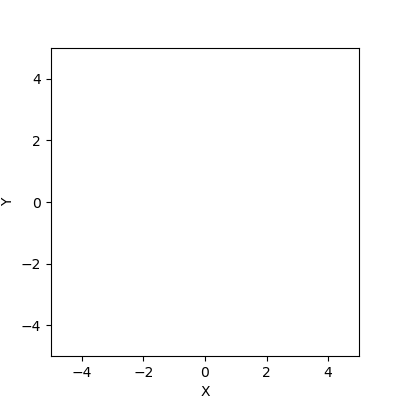

In [13]:
trial()

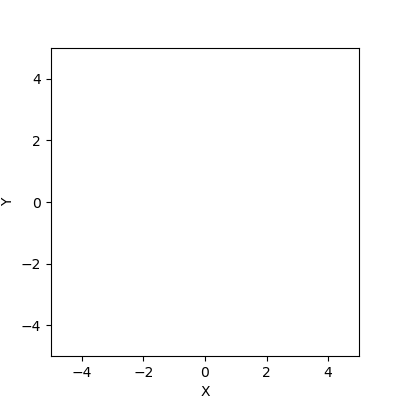

In [17]:
trial(cambias=False)